# Lab 3 — dimensionality reduction

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

from operator import itemgetter

%matplotlib inline
plt.style.use("ggplot")

In [191]:
!hdfs dfs -cat /ix/ml-20m/genome-scores.txt | tail -n 2
!hdfs dfs -cat /ix/ml-20m/movies.txt | tail -n 2
!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 2

{"relevance": 0.11449999999999999, "tagId": 1127, "movieId": 131170}
{"relevance": 0.02174999999999999, "tagId": 1128, "movieId": 131170}
{"genres": ["(no genres listed)"], "movieId": 131260, "title": "Rentun Ruusu (2001)"}
{"genres": ["Adventure", "Fantasy", "Horror"], "movieId": 131262, "title": "Innocence (2014)"}
{"tagId": 1127, "tag": "zombie"}
{"tagId": 1128, "tag": "zombies"}


In [192]:
scores = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)
movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
tags = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)

### Exercise 3.1

In [117]:
from collections import OrderedDict
buildTuple = lambda j: (j['tagId'], (j['movieId'], j['relevance']))
mapped = scores.map(buildTuple).groupByKey().mapValues(lambda ls: OrderedDict(ls)).sortByKey().persist()

#### Exploring the scores data

In [118]:
seqOp = lambda accTup, entry: (   min(accTup[0], len(entry[1])), max(accTup[0], len(entry[1]))   )
combOp = lambda tup1, tup2: (min(tup1[0], tup2[0]), max(tup1[1], tup2[1]))
minV, maxV = mapped.aggregate((movies.count(), 0), seqOp, combOp)
minV == maxV

True

We checked that all the tags are associated to the same number of movies. As the minimum number of movies per tag is equal to the maximum, each movie has a relevance for every tag: the data is not sparse (we did not consider movies without tags)

In [119]:
sc.parallelize(list(range(1, mapped.count() + 1))).subtract(mapped.keys()).count()

0

We checked that the tag ids are sequential integers from $1$ to $max(tagId)$. Therefore we know how to retrieve a tag from the matrix: $tagId = rowNumber + 1$.

Let's build the matrix:

In [120]:
rows = mapped.map(lambda kv: list(kv[1].values()))
M = np.matrix(rows.collect())

Remark that we collect a list of lists. We could use PySparks mllib.linalg to build Vectors and Matrices. However this module uses numpy arrays and matrices on a single machine, therefore this makes no difference.

We compute the matrix $M$


In [121]:
M.shape

(1128, 10381)

Let's center the matrix:

In [122]:
M = M - np.mean(M, axis=0)

#### Question A

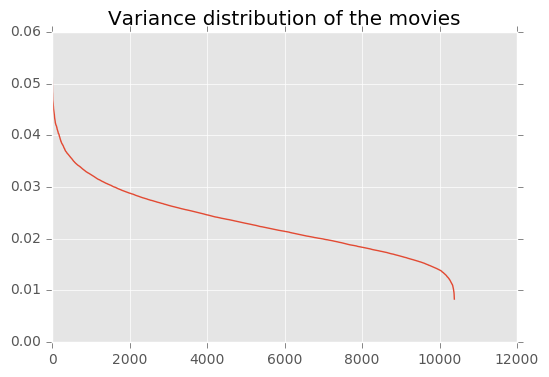

In [123]:
plt.plot(sorted(np.ravel(np.var(M, axis=0)), key=lambda x: -x))
plt.title('Variance distribution of the movies')

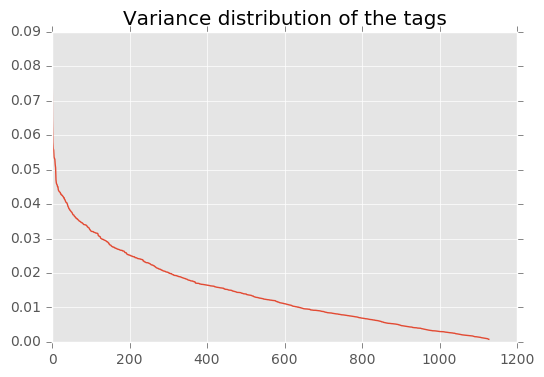

In [124]:
plt.plot(sorted(np.ravel(np.var(M, axis=1)), key=lambda x: -x))
plt.title('Variance distribution of the tags')

#### Question B

In [155]:
C = (M.T @ M) / M.shape[1]
print(C.shape)

(10381, 10381)


In [156]:
sorted_values, vectors = la.eigh(C)
sorted_values = sorted_values[::-1]
vectors = vectors[::-1]

In [157]:
print(sorted_values)

[  9.99887956e+00   1.27298972e+00   8.52412690e-01 ...,  -2.45480427e-16
  -3.25903225e-16  -1.02934514e-15]


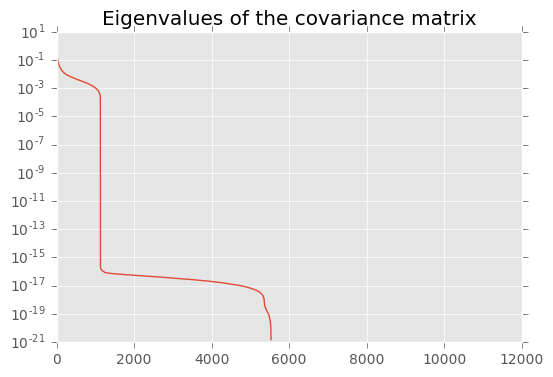

In [158]:
plt.semilogy(sorted_values)
plt.title('Eigenvalues of the covariance matrix')

#### Question C

We can see that eigenvalues fall off very quickly. This means that a few directions can explain the data really well.

#### Conclusion

In [171]:
def directionsVariability(ww, ratio):
    currentRatio = 0.0
    i = 1
    tot = np.sum(ww)
    while currentRatio < ratio:
        currentRatio = np.sum(ww[:i]) / tot
        i += 1
    return i - 1

In [172]:
print('We need', directionsVariability(sorted_values, 2/3), 'directions to explain 2/3 of the variability in the data')

We need 27 directions to explain 2/3 of the variability in the data


### Exercise 3.2

#### Setup

In [190]:
DIRECTIONS = 5

In [180]:
top5values = sorted_values[:DIRECTIONS][::-1]
top5vectors = vectors[:DIRECTIONS][::-1]

In [181]:
top5vectors.shape

(5, 10381)

In [185]:
reduced = M @ top5vectors.T

In [187]:
reduced.shape

(1128, 5)

In [210]:
tag2name = dict(tags.map(itemgetter("tagId", "tag")).collect())

In [207]:
dir_to_best = {}
dir_to_worst = {}
for direction in range(DIRECTIONS):
    tag_to_score = [(tag, reduced[tag, direction]) for tag in range(1128)]
    ordered = sorted(tag_to_score, key=lambda t: -t[1])
    best10 = [tag2name[el[0] + 1] for el in ordered[:10:1]]
    worst10 = [tag2name[el[0] + 1] for el in ordered[::-1][:10]]
    dir_to_best[direction] = best10  
    dir_to_worst[direction] = worst10

In [208]:
dir_to_best

{0: ['downbeat',
  'obsession',
  'bleak',
  'intimate',
  'poignant',
  'oscar (best actress)',
  'nudity (full frontal - notable)',
  'tragedy',
  'enigmatic',
  'melancholy'],
 1: ['touching',
  'childhood',
  'heartwarming',
  'independent film',
  'feel good movie',
  'inspiring',
  'artistic',
  'fun movie',
  'poignant',
  'coming of age'],
 2: ['intimate',
  'fun',
  'kids',
  'family',
  'stunning',
  'forceful',
  'fast paced',
  'melancholy',
  'artistic',
  'complex characters'],
 3: ['drinking',
  'cult classic',
  'family drama',
  'family',
  'cerebral',
  'realistic',
  'music',
  'good soundtrack',
  'surreal',
  'single father'],
 4: ['kids',
  'weapons',
  'action',
  'space',
  'scifi',
  'sacrifice',
  'survival',
  'vigilante',
  'desert',
  'marijuana']}

In [209]:
dir_to_worst

{0: ['action',
  'good action',
  'fight scenes',
  'breathtaking',
  'computer game',
  'beautifully filmed',
  'car chase',
  'exciting',
  'cool',
  'entertaining'],
 1: ['violent',
  'cinematography',
  'detective',
  'suspense',
  'supernatural',
  'bad acting',
  'complex',
  'stylish',
  'revenge',
  'science fiction'],
 2: ['wartime',
  'action packed',
  'war',
  'goofy',
  'big budget',
  'wwii',
  'allegory',
  'historical',
  'period piece',
  'dramatic'],
 3: ['girlie movie',
  'stereotypes',
  'romantic comedy',
  'feel good movie',
  'drama',
  'adapted from:book',
  'chick flick',
  'excellent script',
  'intense',
  'horror'],
 4: ['adapted from:book',
  'erotic',
  'golden palm',
  'cult film',
  'childhood',
  'queer',
  'affectionate',
  'pointless',
  'melancholic',
  'allegory']}

#### Writing file to disk

In [197]:
tagToCoords = {}
for tag in range(1128):
    coords = []
    for direction in range(DIRECTIONS):
        coords.append(reduced[tag, direction])
    tagToCoords[tag2name[tag + 1]] = coords

jsonarray = json.dumps(tagToCoords, ensure_ascii=False)

with open('data.txt', 'w') as dst:
    json.dump(jsonarray, dst)

### Exercise 3.3

In [211]:
import pickle

In [212]:
# Reading an object from disk.
with open("selected-movies.pickle", "rb") as f:
    movies = pickle.load(f, encoding="utf-8")
    
movies = sorted(movies, key=lambda x: x[0])
moviesIds = [movie[0] for movie in movies]

In [213]:
movies

[(260, 'Star Wars: Episode IV - A New Hope (1977)', 0.93),
 (318, 'Shawshank Redemption, The (1994)', 0.91),
 (356, 'Forrest Gump (1994)', 0.72),
 (480, 'Jurassic Park (1993)', 0.93),
 (527, "Schindler's List (1993)", 0.96),
 (780, 'Independence Day (a.k.a. ID4) (1996)', 0.6),
 (805, 'Time to Kill, A (1996)', 0.67),
 (1199, 'Brazil (1985)', 0.98),
 (1240, 'Terminator, The (1984)', 1.0),
 (2324, 'Life Is Beautiful (La Vita è bella) (1997)', 0.8),
 (2329, 'American History X (1998)', 0.83),
 (2571, 'Matrix, The (1999)', 0.87),
 (2706, 'American Pie (1999)', 0.6),
 (2858, 'American Beauty (1999)', 0.88),
 (2959, 'Fight Club (1999)', 0.79),
 (3967, 'Billy Elliot (2000)', 0.85),
 (4465, 'Accused, The (1988)', 0.95),
 (4658, 'Santa Sangre (1989)', 0.85),
 (4700, 'Princess Diaries, The (2001)', 0.47),
 (5147, 'Wild Strawberries (Smultronstället) (1957)', 0.95),
 (5163, 'Stage Fright (Deliria) (1987)', 0.68),
 (5349, 'Spider-Man (2002)', 0.89),
 (5687, 'Take Care of My Cat (Goyangileul butagha

#### Question A

In [252]:
newMatrix = scoresGetter.map(itemgetter('movieId', 'relevance')).groupByKey().sortByKey().filter(lambda x: x[0] in moviesIds).map(lambda x: list(x[1])).collect()

In [253]:
newX = np.matrix(newMatrix)

print(newX.shape)

(37, 1128)


In [254]:
w2, v2 = principalDirectionsDecomposition(2, w, v)

In [255]:
projectedMatrix = (newX * v2).tolist()

In [256]:
print(projectedMatrix)

[[2.0893300546353504, -5.426914790378008], [4.7798756527706905, -7.005831293614132], [3.0891068583586843, -5.720596389488723], [0.5040908679323646, -4.657254604744452], [5.235154169255041, -5.9820308465410825], [-0.619546763288653, -3.638962682158663], [1.5902876955488527, -4.038491906764626], [3.9257951449722626, -5.198879006577363], [1.8429495418955506, -5.1268531813498015], [3.9822373589623643, -5.554794560022297], [5.291756690454118, -6.613882098485531], [2.6775037703474904, -6.027528562757453], [-0.11269701696355026, -3.800151139869716], [5.515006342204587, -6.8633884716835185], [4.979014694817191, -7.047067473896883], [2.9620590971683987, -4.574748022110336], [3.4184561597469916, -4.939231614220861], [3.5535225294013144, -4.411486955895904], [-0.8886969971584623, -2.5571835583797444], [5.271580829677336, -5.5090613838925275], [2.4464763192971968, -4.013630946662102], [-0.36545729277637856, -4.175436808630352], [1.7586746876617503, -2.108221973526682], [5.7563527389843845, -6.8083

In [257]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()

Loading BokehJS ...

In [258]:
# Categorial colors
from bokeh.palettes import Dark2_8
from matplotlib.colors import rgb2hex 

cmap = plt.get_cmap('viridis')
def val2rgb(val):
    return rgb2hex(cmap(val)[:3])

source = ColumnDataSource(
    data={
        "x": [x[0] for x in projectedMatrix],
        "y": [x[1] for x in projectedMatrix],
        "name": [x for x in movies],
        "color": [val2rgb(x[2]) for x in movies],
    })

hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=960, plot_height=360, tools=tools, title="Mouse over the dots")
p.circle("x", "y", source=source, size=20, color="color", alpha=0.5)
show(p, notebook_handle=True)

#### Question 2

#### Question 3